In [2]:
%load_ext autoreload

# Enable autoreload for all modules
%autoreload 2

import sys
sys.path.append("..")

from loader import graph_loader
import numpy as np 
import matplotlib.pyplot as plt
import torch

from graph_plotting import graph_2D
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool
from models import graph_classifier, gnn_models
from torch_geometric.loader import DataLoader
from torch_geometric.loader import NeighborLoader, GraphSAINTRandomWalkSampler
from torch_geometric.data import HeteroData
from loader.custom_loader import RandomWalkIterator, NeighborIterator, RectangularIterator

from torch_geometric.nn import to_hetero
from torch_geometric import transforms

#import torch_geometric

from evaluation import evaluation
from patch_evaluation import patch_evaluation

In [5]:
#octa500_loader_4_cls = graph_loader.GraphLoaderTorch("/media/data/alex_johannes/octa_data/graphs", "/media/data/alex_johannes/octa_data/labels.xlsx", two_cls= False)
octa500_loader_2_cls = graph_loader.GraphLoaderTorch("/media/data/alex_johannes/octa_data/graphs", "/media/data/alex_johannes/octa_data/labels.xlsx", two_cls= True, create_line= True)


In [3]:
np.random.seed(0)

work_data = octa500_loader_2_cls.line_data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_mask = np.random.choice(np.arange(0, len(work_data)), size= int(len(work_data)*0.8), replace = False)
test_mask = np.delete(np.arange(0, len(work_data)), train_mask)

train_list_bin = []
test_list_bin = []

for i, data in enumerate(work_data.values()):
    if i in train_mask:
        train_list_bin.append(data.to(device))
    else:
        test_list_bin.append(data.to(device))

/home/alex_johannes/octa_gnn/OCTA_gnn/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch: 001, Loss: 0.028388, Train Acc: 0.8438, Test Acc: 0.9000, Test Bal Acc: 0.5000
Epoch: 002, Loss: 0.022147, Train Acc: 0.1562, Test Acc: 0.1000, Test Bal Acc: 0.5000
Epoch: 003, Loss: 0.022172, Train Acc: 0.1562, Test Acc: 0.1000, Test Bal Acc: 0.5000
Epoch: 004, Loss: 0.021005, Train Acc: 0.8750, Test Acc: 0.9000, Test Bal Acc: 0.9444
Epoch: 005, Loss: 0.021046, Train Acc: 0.1562, Test Acc: 0.1000, Test Bal Acc: 0.5000
Epoch: 006, Loss: 0.021707, Train Acc: 0.1562, Test Acc: 0.1000, Test Bal Acc: 0.5000
Epoch: 007, Loss: 0.020365, Train Acc: 0.9000, Test Acc: 1.0000, Test Bal Acc: 1.0000
Epoch: 008, Loss: 0.020267, Train Acc: 0.9125, Test Acc: 0.9500, Test Bal Acc: 0.9722
Epoch: 009, Loss: 0.019814, Train Acc: 0.9250, Test Acc: 1.0000, Test Bal Acc: 1.0000
Epoch: 010, Loss: 0.019118, Train Acc: 0.9313, Test Acc: 1.0000, Test Bal Acc: 1.0000
Epoch: 011, Loss: 0.018358, Train Acc: 0.9187, Test Acc: 0.9500, Test Bal Acc: 0.9722
Epoch: 012, Loss: 0.017728, Train Acc: 0.9187, Test Ac

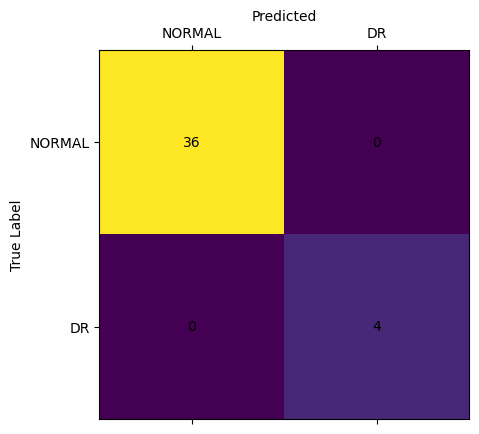

In [4]:
# selection of the features to use
num_features = train_list_bin[0].x.shape[1]
num_classes = 2
epochs = 50

# try different aggregation modes:
# other aggragtion schemas not supported for batches


# create the model
model = gnn_models.GNN(in_channels= num_features, hidden_channels = 64, out_channels= num_classes, num_layers= 5, dropout = 0.2, aggregation_mode= global_mean_pool)

# create brach data loaders for training and test set
train_loader = DataLoader(train_list_bin, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_list_bin, batch_size = 1, shuffle=False)

#train_loader = NeighborIterator(train_list_bin, neighborhood_size=50, start_node_fraction=0.01)
#test_loader = NeighborIterator(test_list_bin, neighborhood_size=50, start_node_fraction=0.01)

#train_loader = RectangularIterator(train_list_bin, selections_per_graph=10, rect_size=300)
#test_loader = RectangularIterator(test_list_bin, selections_per_graph=10, rect_size=300)

# weigthings for imbalanced classes 
train_labels = [lab["y"].cpu() for lab in train_list_bin]
weights = 1/np.unique(train_labels, return_counts= True)[1]
balanced_loss = torch.nn.CrossEntropyLoss(torch.tensor(weights).to(device).float())
unbalanced_loss = torch.nn.CrossEntropyLoss() # use when the training data is already balanced

# trainloader can be anything 
classifier = graph_classifier.graphClassifierClassic(model, train_loader, test_loader, balanced_loss)


for epoch in range(1, epochs+1):
    loss = classifier.train()
    train_acc = classifier.test(train_loader)
    #test_acc = classifier.test(test_loader)
    outList, yList = classifier.predict(test_loader)
    y_p = np.array([item.argmax().cpu().detach().numpy() for sublist in outList for item in sublist])
    y_t = np.array([item.detach().cpu().numpy() for sublist in yList for item in sublist])
    print(f'Epoch: {epoch:03d}, Loss: {loss:.6f}, Train Acc: {train_acc:.4f}, Test Acc: {accuracy_score(y_t, y_p):.4f}, Test Bal Acc: {balanced_accuracy_score(y_t, y_p):.4f}')


fig, ax = plt.subplots()
#evaluation.plot_confusion_matrix(y_t, y_p, ["NORMAL", "DR", "CNV", "AMD"], ax)
evaluation.plot_confusion_matrix(y_t, y_p, ["NORMAL", "DR"], ax)

In [58]:
from torch_geometric.utils import contains_self_loops, remove_self_loops

region_graph_loader_2_cls = graph_loader.GraphLoaderTorch("/media/data/alex_johannes/octa_data/void_graphs", "/media/data/alex_johannes/octa_data/labels.xlsx", two_cls= True, create_line= False)

# remove the first 2 features (x and y coordinates)

for data in region_graph_loader_2_cls.full_data.values():
    data.x = data.x[:,2:]
    data.edge_index, data.edge_attr = remove_self_loops(data.edge_index,data.edge_attr)

In [ ]:
# void to vessel index needs to 

In [92]:
combined_graphs = []

for i in range(10301,10500):
    het_dat = HeteroData()

    het_dat['void'].x = region_graph_loader_2_cls.full_data[i].x
    het_dat['vessel'].x = octa500_loader_2_cls.line_data[i].x

    het_dat.y = octa500_loader_2_cls.line_data[i].y

    het_dat['void', 'to', 'void'].edge_index = region_graph_loader_2_cls.full_data[i].edge_index
    het_dat['vessel', 'to', 'vessel'].edge_index = octa500_loader_2_cls.line_data[i].edge_index



    # make the graph more more 
    het_dat['vessel', 'to', 'void'].edge_index = torch.tensor([[100,120],[200,220]])
    het_dat = transforms.ToUndirected()(het_dat[0])

    combined_graphs.append(het_dat)




    #could do a distance based edge index between vessels and void regions
    # but doesnt really make sense because large regions will not connect boardering vessel

    # could do a intersection based method



In [94]:
print(combined_graphs[0].is_undirected())


data = transforms.ToUndirected()(combined_graphs[0])
#transforms.to_undirected.to_undirected(combined_graphs[0])

data['vessel', 'to', 'void']
data

False


HeteroData(
  y=[1],
  void={ x=[2344, 10] },
  vessel={ x=[8506, 17] },
  (void, to, void)={ edge_index=[2, 15218] },
  (vessel, to, vessel)={ edge_index=[2, 34038] },
  (vessel, to, void)={ edge_index=[2, 2] },
  (void, rev_to, vessel)={ edge_index=[2, 2] }
)

In [60]:
np.random.seed(0)

work_data = combined_graphs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_mask = np.random.choice(np.arange(0, len(work_data)), size= int(len(work_data)*0.8), replace = False)
test_mask = np.delete(np.arange(0, len(work_data)), train_mask)

train_list_bin = []
test_list_bin = []

for i, data in enumerate(work_data):
    if i in train_mask:
        train_list_bin.append(data.to(device))
    else:
        test_list_bin.append(data.to(device))

In [61]:
work_data[0]

HeteroData(
  y=[1],
  void={ x=[2344, 10] },
  vessel={ x=[8506, 17] },
  (void, to, void)={ edge_index=[2, 7609] },
  (vessel, to, vessel)={ edge_index=[2, 17058] }
)

Epoch: 001, Loss: 0.258661, Train Acc: 0.1698, Test Acc: 0.0500, Test Bal Acc: 0.5000
Epoch: 002, Loss: 0.038836, Train Acc: 0.9119, Test Acc: 1.0000, Test Bal Acc: 1.0000
Epoch: 003, Loss: 0.014313, Train Acc: 0.3836, Test Acc: 0.2500, Test Bal Acc: 0.6053
Epoch: 004, Loss: 0.020351, Train Acc: 0.9182, Test Acc: 1.0000, Test Bal Acc: 1.0000
Epoch: 005, Loss: 0.014926, Train Acc: 0.9119, Test Acc: 1.0000, Test Bal Acc: 1.0000
Epoch: 006, Loss: 0.013540, Train Acc: 0.8428, Test Acc: 0.8750, Test Bal Acc: 0.9342
Epoch: 007, Loss: 0.012618, Train Acc: 0.9182, Test Acc: 1.0000, Test Bal Acc: 1.0000
Epoch: 008, Loss: 0.014823, Train Acc: 0.9119, Test Acc: 1.0000, Test Bal Acc: 1.0000
Epoch: 009, Loss: 0.015349, Train Acc: 0.8931, Test Acc: 0.8750, Test Bal Acc: 0.9342
Epoch: 010, Loss: 0.012891, Train Acc: 0.9119, Test Acc: 1.0000, Test Bal Acc: 1.0000
Epoch: 011, Loss: 0.014661, Train Acc: 0.8365, Test Acc: 0.8750, Test Bal Acc: 0.9342
Epoch: 012, Loss: 0.012884, Train Acc: 0.9119, Test Ac

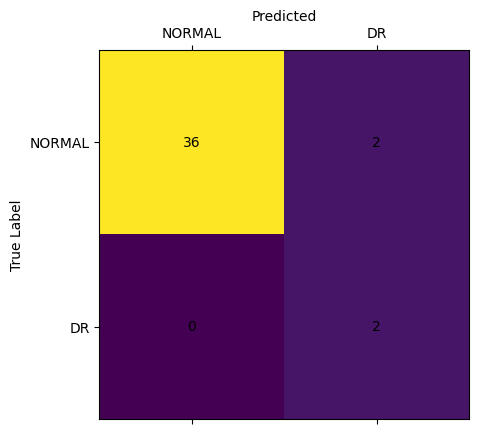

In [62]:
num_classes = 2
epochs = 50

# create the model
model = gnn_models.HeteroGNN(hidden_channels = 64, 
                          out_channels= num_classes, 
                          num_layers= 5, 
                          dropout = 0.2, 
                          aggregation_mode= global_mean_pool,
                          )
# create brach data loaders for training and test set
train_loader = DataLoader(train_list_bin, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_list_bin, batch_size = 1, shuffle=False)


# weigthings for imbalanced classes 
train_labels = [lab["y"].cpu() for lab in train_list_bin]
weights = 1/np.unique(train_labels, return_counts= True)[1]
balanced_loss = torch.nn.CrossEntropyLoss(torch.tensor(weights).to(device).float())
unbalanced_loss = torch.nn.CrossEntropyLoss() # use when the training data is already balanced

# trainloader can be anything 
classifier = graph_classifier.graphClassifierHetero(model, train_loader, test_loader, balanced_loss)


for epoch in range(1, epochs+1):
    loss = classifier.train()
    train_acc = classifier.test(train_loader)
    outList, yList = classifier.predict(test_loader)
    y_p = np.array([item.argmax().cpu().detach().numpy() for sublist in outList for item in sublist])
    y_t = np.array([item.detach().cpu().numpy() for sublist in yList for item in sublist])
    print(f'Epoch: {epoch:03d}, Loss: {loss:.6f}, Train Acc: {train_acc:.4f}, Test Acc: {accuracy_score(y_t, y_p):.4f}, Test Bal Acc: {balanced_accuracy_score(y_t, y_p):.4f}')


fig, ax = plt.subplots()
#evaluation.plot_confusion_matrix(y_t, y_p, ["NORMAL", "DR", "CNV", "AMD"], ax)
evaluation.plot_confusion_matrix(y_t, y_p, ["NORMAL", "DR"], ax)

In [ ]:
region_graph_loader_2_cls.full_data[10301]

#graph_2D.GraphPlotter2D(region_graph_loader_2_cls.full_data[10301]).plot_graph_2D()#.plot_graph_2D(

Data(x=[2293, 10], edge_index=[2, 8269], edge_attr=[8269, 0], y=[1], pos=[2293, 2], edge_pos=[8269, 2], graph_id=10301)

In [11]:
np.random.seed(0)

work_data = region_graph_loader_2_cls.full_data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_mask = np.random.choice(np.arange(0, len(work_data)), size= int(len(work_data)*0.8), replace = False)
test_mask = np.delete(np.arange(0, len(work_data)), train_mask)

train_list_bin = []
test_list_bin = []

for i, data in enumerate(work_data.values()):
    if i in train_mask:
        train_list_bin.append(data.to(device))
    else:
        test_list_bin.append(data.to(device))

Epoch: 001, Loss: 1.717642, Train Acc: 0.1562, Test Acc: 0.1000, Test Bal Acc: 0.5000
Epoch: 002, Loss: 0.057891, Train Acc: 0.8438, Test Acc: 0.9000, Test Bal Acc: 0.5000
Epoch: 003, Loss: 0.038299, Train Acc: 0.1562, Test Acc: 0.1000, Test Bal Acc: 0.5000
Epoch: 004, Loss: 0.025938, Train Acc: 0.8500, Test Acc: 0.9000, Test Bal Acc: 0.5000
Epoch: 005, Loss: 0.024414, Train Acc: 0.1562, Test Acc: 0.1000, Test Bal Acc: 0.5000
Epoch: 006, Loss: 0.019724, Train Acc: 0.2000, Test Acc: 0.1500, Test Bal Acc: 0.5278
Epoch: 007, Loss: 0.018801, Train Acc: 0.8438, Test Acc: 0.9000, Test Bal Acc: 0.5000
Epoch: 008, Loss: 0.021578, Train Acc: 0.4375, Test Acc: 0.4500, Test Bal Acc: 0.6944
Epoch: 009, Loss: 0.022446, Train Acc: 0.4688, Test Acc: 0.4750, Test Bal Acc: 0.7083
Epoch: 010, Loss: 0.018165, Train Acc: 0.9000, Test Acc: 0.9000, Test Bal Acc: 0.9444
Epoch: 011, Loss: 0.016238, Train Acc: 0.9062, Test Acc: 1.0000, Test Bal Acc: 1.0000
Epoch: 012, Loss: 0.017995, Train Acc: 0.9125, Test Ac

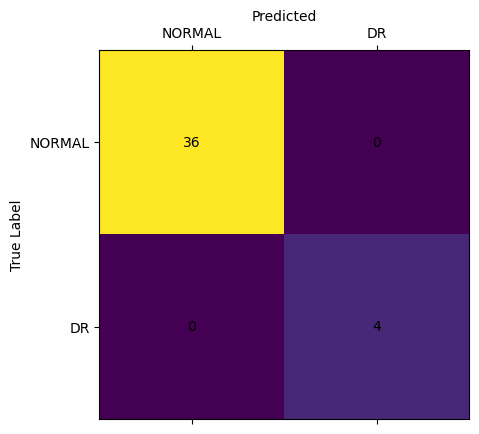

In [12]:
# selection of the features to use
num_features = train_list_bin[0].x.shape[1]
num_classes = 2
epochs = 50

# try different aggregation modes:
# other aggragtion schemas not supported for batches


# create the model
model = gnn_models.GNN(in_channels= num_features, hidden_channels = 64, out_channels= num_classes, num_layers= 5, dropout = 0.2, aggregation_mode= global_mean_pool)

# create brach data loaders for training and test set
train_loader = DataLoader(train_list_bin, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_list_bin, batch_size = 1, shuffle=False)

# weigthings for imbalanced classes 
train_labels = [lab["y"].cpu() for lab in train_list_bin]
weights = 1/np.unique(train_labels, return_counts= True)[1]
balanced_loss = torch.nn.CrossEntropyLoss(torch.tensor(weights).to(device).float())
unbalanced_loss = torch.nn.CrossEntropyLoss() # use when the training data is already balanced

# trainloader can be anything 
classifier = graph_classifier.graphClassifierClassic(model, train_loader, test_loader, balanced_loss)

for epoch in range(1, epochs+1):
    loss = classifier.train()
    train_acc = classifier.test(train_loader)
    #test_acc = classifier.test(test_loader)
    outList, yList = classifier.predict(test_loader)
    y_p = np.array([item.argmax().cpu().detach().numpy() for sublist in outList for item in sublist])
    y_t = np.array([item.detach().cpu().numpy() for sublist in yList for item in sublist])
    print(f'Epoch: {epoch:03d}, Loss: {loss:.6f}, Train Acc: {train_acc:.4f}, Test Acc: {accuracy_score(y_t, y_p):.4f}, Test Bal Acc: {balanced_accuracy_score(y_t, y_p):.4f}')


fig, ax = plt.subplots()
#evaluation.plot_confusion_matrix(y_t, y_p, ["NORMAL", "DR", "CNV", "AMD"], ax)
evaluation.plot_confusion_matrix(y_t, y_p, ["NORMAL", "DR"], ax)

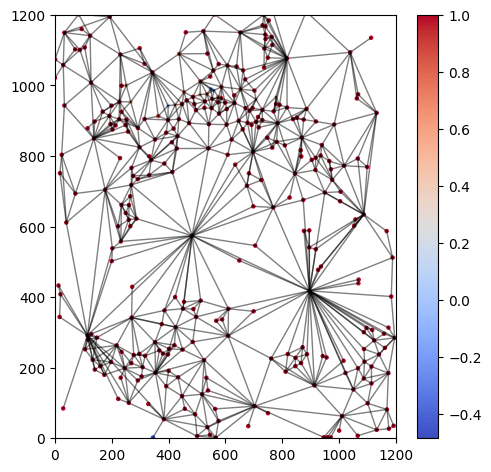

In [19]:
void_graph_work = region_graph_loader_2_cls.full_data[10380]


out = classifier.model.vals_without_aggregation(void_graph_work.x, void_graph_work.edge_index, void_graph_work.batch)
mean_vals = out[:,1] - out[:,0]
graph_2D.GraphPlotter2D(void_graph_work, pred_vals=mean_vals.cpu().detach().numpy()).plot_graph_2D()#.plot_graph_2D()

In [ ]:
# evaluate on partitions:

#test_loader_regions = RectangularIterator(test_list_bin, selections_per_graph=100, rect_size=300, stratified= False, shuffle= False)
train_loader_regions = RectangularIterator(train_list_bin, selections_per_graph=400, rect_size=150, stratified= False, shuffle= False)

loader_sel = train_loader_regions

outList, yList = classifier.predict(loader_sel)
last_id_list =loader_sel.last_id_list
last_region_list =loader_sel.last_region_list

In [ ]:
ids = [graph.graph_id for graph in train_list_bin]
labs = [int(graph.y[0]) for graph in train_list_bin]
diseased_idx = np.where(np.array(labs) == 1)[0]

In [ ]:
diseased_idx

array([  3,   5,   9,  13,  15,  21,  28,  36,  39,  43,  53,  54,  64,
        66,  71,  92,  96, 106, 107, 110, 119, 123, 133, 142, 158])

In [ ]:

ct = 0
train_loader = DataLoader(train_list_bin, batch_size = 1, shuffle=False)
for data in train_loader:
    ct+=1
    print(data.graph_id[0].item())
    fig, ax = plt.subplots(1,2, figsize=(12,5))

    out = classifier.model.vals_without_aggregation(data.x, data.edge_index, data.batch)
    mean_vals = out[:,1] - out[:,0]
    graph_2D.GraphPlotter2D(octa500_loader_2_cls.line_data[data.graph_id[0].item()], line_G = True, pred_vals=mean_vals.cpu().detach().numpy()).plot_graph_2D(ax[0])#.plot_graph_2D()
    mean_vals = patch_evaluation.nodewise_mean_val(octa500_loader_2_cls, data.graph_id[0].item(), last_id_list, last_region_list, outList)
    graph_2D.GraphPlotter2D(octa500_loader_2_cls.line_data[data.graph_id[0].item()], line_G = True, pred_vals=mean_vals).plot_graph_2D(ax[1])

    plt.show()

    if ct == 20:
        break

In [ ]:

#for n_id_idx in np.arange(160):#diseased_idx:#np.arange(29,50,1):
#    n_id = ids[n_id_idx]
#    print(n_id_idx)
#    print(n_id)
#    mean_vals = nodewise_mean_val(octa500_loader_2_cls, n_id, last_id_list, last_region_list, outlist_conv)
#    graph_2D.GraphPlotter2D(octa500_loader_2_cls.line_data[n_id], line_G = True, pred_vals=mean_vals).plot_graph_2D()#.plot_graph_2D()
    #print(mean_vals)


    #break

In [ ]:


for n_id_idx in np.arange(160):#diseased_idx:#np.arange(29,50,1):
    n_id = ids[n_id_idx]
    print(n_id_idx)
    print(n_id)
    graph_2D.GraphPlotter2D(octa500_loader_2_cls.full_data[n_id]).plot_graph_2D()#.plot_graph_2D()
    break